# 1. Imports 

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
import ipynb.fs.full
import import_ipynb
from PVM import PVM
from Agents.DPG_NoCash import DPG
from MarketEnvironment import MarketEnvironment

import ffn
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import deque

import tensorflow as tf

# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

importing Jupyter notebook from PVM.ipynb
importing Jupyter notebook from MarketEnvironment.ipynb


# 2. Load Parameters

In [2]:
# Load market data tensor 
periods = '2012-01-01_2020-01-01'
path_data = './MarketData/np_data/input_' + periods + '_closeNorm.npy'
# path_data = './MarketData/np_data/input_2014-01-01_2020-06-23.npy'
# path_data = './MarketData/np_data/input_2008-01-01_2010-01-01.npy'
data = np.load(path_data)       # Load data
trading_period = data.shape[2]  # All the periods for which feature prices are recorded
num_features = data.shape[0]    # Number of feature prices
num_assets = data.shape[1]      # Number of market assets

m = num_assets
asset_list = ['SAN.MC', 'TEF.MC', 'GRF.MC', 'BIO.MC', 'FAE.MC', 'AIR.MC', 'IDR.MC', 'ITX.MC', 'SLR.MC']
# asset_list = [i for i in range(m)]

training_validating_testing = {'train_ratio': 0.6, 'validation_ratio': 0.2}
training_parameters = {'num_epochs': 10, 'num_batches': 30, 'batch_size': 20}
network_parameters = {'regularization': 1e-8, 'learning': 9e-4, 'window_size': 50}
financial_information = {'trading_cost': 0.25/100, 'interest_rate': 0.02/250}
investing_information = {'initial_portfolio_value': 10000, 'initial_weight_vector': np.array(np.array([1]+[0]*m))}

# Trading steps/periods (days) for training, validations and testing sets:
training_set_periods = int(training_validating_testing['train_ratio']*trading_period)
validating_set_periods = int(training_validating_testing['validation_ratio']*trading_period)
testing_set_periods = trading_period-training_set_periods - validating_set_periods

# Training parameters
num_epochs = training_parameters['num_epochs']
num_batches = training_parameters['num_batches']
batch_size = training_parameters['batch_size']

# Network optimization parameters:
regularization = network_parameters['regularization']  # The L2 regularization coefficient applied to network training
learning = network_parameters['learning']              # Parameter alpha (i.e. the step size) of the Adam optimization
optimizer = tf.train.AdamOptimizer(learning)
n = network_parameters['window_size']

# Financial parameters
trading_cost = financial_information['trading_cost']
interest_rate = financial_information['interest_rate']

# Investing_information
w_init = investing_information['initial_weight_vector']           # Before starting to trade, all the portfolio is composed by cash 
pf_value_init = investing_information['initial_portfolio_value']  # Amount of cash the agent is going to invest

# PVM Parameters
sample_bias = 5e-5  # Beta in the geometric distribution for mini-batch training sample batches

import datetime
Dates = pd.read_csv('MarketData/Madrid_SE_' + periods + '/' + 'AIR.MC.csv',).Date
Dates = Dates[:-1]
train_dates = list(Dates[n : training_set_periods])
val_dates = list(Dates[training_set_periods + n : training_set_periods + validating_set_periods])
test_dates = list(Dates[training_set_periods + validating_set_periods + n : ])

# 3.Test Performance

## 3.1 Compute portfolio values for each period of the testing set 
Compute the agent's action in the testing set and the new portfolio value after the taken action. If individual_assets = True, it computes the portfolio values of a portfolio composed of a single asset. This is done for all the assets.

In [4]:
def validate_agent(agent, LogReturn = True):
       
    # Create the trading environment and initializate it with initial weight and portfolio value
    # n + t is where it starts reading the data
    env = MarketEnvironment(path = path_data, window_length = n,
                   initial_portfolio_value = pf_value_init, trading_cost = trading_cost,
                   interest_rate = interest_rate, train_size = training_validating_testing['train_ratio'],
                   LogReturn = LogReturn)
    # The first period that the net is going to compute is training_set_periods + n 
    # cause it needs the n previous periods to compute tha action
    state, done = env.reset(w_init[1:], pf_value_init, t = training_set_periods)

    # First element of the portfolio value and the weight vector
    p_list = [pf_value_init]
    w_list = [w_init[1:]]
    rewards = list()

    # Reads from training_set_periods (first validating set index) + n 
    # until the last validating set index minus n because the last index of the market environment is
    # MarketEnvironment.index = training_set_periods + validating_set_periods + n - n
    # And X_last = data[:,:,index-n:index]
    for k in range(training_set_periods + 1, training_set_periods + validating_set_periods - n):
        # Reshape the tensors adding one dimension for the batches to feed the into the NN
        X_t = state[0].reshape([-1] + list(state[0].shape))
        X_t = X_t[:,:-1,:,:]
        W_previous = state[1].reshape([-1]+ list(state[1].shape))
        pf_value_previous = state[2]
        
        # Compute the action the agent takes (once the parameters of the net have been trained) 
        action = agent.compute_W(X_t, W_previous)
       
        # Forward step: compute new environment state
        state, reward, done = env.step(action)
        rewards.append(reward)
        
        X_next = state[0]                  # X[:, :, t+1-n:t+1]
        W_t = state[1]                     # Action at the end of the trading period (contains price fluctuations)
        pf_value_t  = state[2]             # Portfolio value at the end of the trading period
        dailyReturn_t = X_next[-1, :, -1]  # X[opening/opening, :, t+1] = opening(t+1)/opening(t)
        
        #print('current portfolio value', round(pf_value_previous,0))
        #print('weights', W_previous)
        p_list.append(pf_value_t)  # List of the portfolio values after each step
        w_list.append(W_t)         # List of the actions taken by the agent after each step
        
    
    rewards = np.array(rewards)
    sharpe_ratio = np.mean(rewards)/np.std(rewards)
    print('Sharpe Ratio over backtest periods = {}'.format(sharpe_ratio))
    profit = p_list[-1]/p_list[0]
    print('Profit over backtest periods (pvalue_f/pvalue_i) = {}'.format(profit))
    return p_list, w_list

In [5]:
def test_agent(env, agent, m, window_length, training_set_periods, validating_set_periods, 
               testing_set_periods, LogReturn = True, individual_assets = False):
    
    # Evaluate each asset separately to analyze if the agent should invest more money in a specific stock
    if individual_assets:
        # Initialize vectors and lists to record values   
        state_fu = [0]*m; done_fu = [0]*m
        action_fu = list(); env_fu = list(); p_list_fur = list()
        for i in range(m):
            action = np.array([0]*(i) + [1] + [0]*(m-(i+1)))
            action_fu.append(action)
            
            # The environment starts in window length + training_set_periods + validating_set_periods
            env_fu_i = MarketEnvironment(path = path_data, window_length = window_length,
                       initial_portfolio_value=pf_value_init, trading_cost=trading_cost,
                       interest_rate=interest_rate, train_size=training_validating_testing['train_ratio'], LogReturn = LogReturn)

            env_fu.append(env_fu_i)
            state_fu[i],  done_fu[i] = env_fu[i].reset(action_fu[i], pf_value_init, t = training_set_periods + validating_set_periods)
            p_list_fur.append([pf_value_init])


    pf_value_t_fu = [0]*m
    # Initialize environment
    # Reset environment to start the trading once the agent has been trained 
    # First period is going to compute is t = training_set_periods + validating_set_periods + window_length
    # where training_set_periods + validating_set_periods is the first index of the testing set
    # the window_length is summed in the MarketEnvironment class internally because the net need to explore 
    # window_length periods to compute te action (explore the potential of growth)
    state, done = env.reset(w_init[1:], pf_value_init, t = training_set_periods + validating_set_periods)
    
    # First elements of portfolio values and weight vectors. New values will be append after computing them for each periods
    p_list = [pf_value_init]
    w_list = [w_init[1:]]
    
    # Keep track of the rewards obtained during the whole trading period
    rewards = list()

    # Run the NN to compute 
#     print('Print action results every 20 periods:')
    # Compute from training_set_periods + validating_set_periods + window_length (to consider the window_length history price)
    # untill training_set_periods + validating_set_periods + testing_set_periods - window_length + window_length
    for k in range(training_set_periods + validating_set_periods, training_set_periods + validating_set_periods + testing_set_periods - window_length):
        # Read state values
        X_t = state[0].reshape([-1] + list(state[0].shape))
        X_t = X_t[:,:-1,:,:]
        W_previous = state[1].reshape([-1] + list(state[1].shape))
        pf_value_previous = state[2]
        
        # Compute action 
        action = agent.compute_W(X_t, W_previous)
        
        # Compute the tensors for the next step  
        state, reward, done = env.step(action)
        rewards.append(reward)
        
        X_next = state[0]
        dailyReturn_t = X_next[-1, :, -1]
        W_t = state[1]   # Weights after the price fluctuation
        pf_value_t = state[2]
        
        # Append results
        p_list.append(pf_value_t)
        w_list.append(W_t)
        
        # Print results of the actions taken every 20 steps
#         if k%20 == 0:
#             print('current portfolio value', round(pf_value_previous, 0))
#             print('weights', W_previous)
# #             print('sum weights', np.sum(W_previous))

    
        if individual_assets:
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
                pf_value_t_fu[i] = state_fu[i][2]
                p_list_fur[i].append(pf_value_t_fu[i])

#         if k == training_set_periods +validating_set_periods-int(n/2) + 100:
#             break
     
    rewards = np.array(rewards)
    sharpe_ratio = np.mean(rewards)/np.std(rewards)
    print('Sharpe Ratio over backtest periods = {}'.format(sharpe_ratio))
    profit = p_list[-1]/p_list[0]
    print('Profit over backtest periods (pvalue_f/pvalue_i) = {}'.format(profit))
    if individual_assets:
        return p_list, w_list, p_list_fur
    else:
        return p_list, w_list

## 4.1 Instanciate agents to test

### 4.1.1 Not trained agent

In [6]:
tf.reset_default_graph()
device = 'cpu'
path_to_save = 'ModelParams/'
model_name = 'modelC.ckpt'
env_log = MarketEnvironment(path = path_data, window_length = n,
               initial_portfolio_value = pf_value_init, trading_cost = trading_cost,
               interest_rate = interest_rate, train_size = training_validating_testing['train_ratio'], LogReturn = True)

load_weights = False
if device == "cpu":
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    with tf.device("/cpu:0"):
        not_trained = DPG(num_features-1, m, n, device, optimizer, trading_cost, interest_rate, 
                       path_to_save, model_name, LogReturn = True, load_weights = load_weights)
else:
    not_trained = DPG(num_features-1, m, n, device, optimizer, trading_cost, interest_rate, 
                   path_to_save, model_name, LogReturn = True, load_weights = load_weights)
    


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 4.1.2 Trained agent maximizing Sharpe Ratio (SR)

In [ ]:
# Initialize session and run it so as to train the agent
tf.reset_default_graph()
device = 'cpu'
path_to_save = 'ModelParams_S_closeNorm/'
model_name = 'Model2_n50_s9_9e-4_bs20.ckpt'
env = MarketEnvironment(path = path_data, window_length = n,
               initial_portfolio_value = pf_value_init, trading_cost = trading_cost,
               interest_rate = interest_rate, train_size = training_validating_testing['train_ratio'], LogReturn = True)

load_weights = True
if device == "cpu":
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    with tf.device("/cpu:0"):
        trained_agent_S = DPG(num_features-1, m, n, device, optimizer, trading_cost, interest_rate, 
                       path_to_save, model_name, LogReturn = True, load_weights = load_weights)
else:
    trained_agent_S = DPG(num_features-1, m, n, device, optimizer, trading_cost, interest_rate, 
                   path_to_save, model_name, LogReturn = True, load_weights = load_weights)

### 4.1.3 Trained agent maximizing Log Return (LR)

In [8]:
# Initialize session and run it so as to train the agent
tf.reset_default_graph()
device = 'cpu'
path_to_save = 'ModelParams_LR_closeNorm/'
model_name = 'Model2_x1000000_n50_s9_9e-4_bs20.ckpt'
env = MarketEnvironment(path = path_data, window_length = n,
               initial_portfolio_value = pf_value_init, trading_cost = trading_cost,
               interest_rate = interest_rate, train_size = training_validating_testing['train_ratio'], LogReturn = True)

load_weights = True
if device == "cpu":
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    with tf.device("/cpu:0"):
        trained_agent_LR = DPG(num_features-1, m, n, device, optimizer, trading_cost, interest_rate, 
                       path_to_save, model_name, LogReturn = True, load_weights = load_weights)
else:
    trained_agent_LR = DPG(num_features-1, m, n, device, optimizer, trading_cost, interest_rate, 
                   path_to_save, model_name, LogReturn = True, load_weights = load_weights)

Loading Model
Saved to:ModelParams_LR_closeNorm/
model_checkpoint_path: "ModelParams_LR_closeNorm/Model2_n50_s9_9e-4_bs20_reg2_retrained.ckpt"
all_model_checkpoint_paths: "ModelParams_LR_closeNorm/Model2_n50_s9_9e-4_bs20_reg2_retrained.ckpt"
 ModelParams_LR_closeNorm/Model2_n50_s9_9e-4_bs20_reg2_retrained.ckpt
INFO:tensorflow:Restoring parameters from ModelParams_LR_closeNorm/Model2_n50_s9_9e-4_bs20_reg2_retrained.ckpt
Successfully loaded: ModelParams_LR_closeNorm/Model2_n50_s9_9e-4_bs20_reg2_retrained.ckpt


## 4.2 Portfolio values for each agent

### 4.2.1 Validation set

In [9]:
pv_val_not_trained, w_val_not_trained = validate_agent(not_trained)

Sharpe Ratio over backtest periods = 0.10756039255832164
Profit over backtest periods (pvalue_f/pvalue_i) = 1.5270506383154723


In [10]:
pv_val_LR_trained, w_val_LR_trained = validate_agent(trained_agent_LR)

Sharpe Ratio over backtest periods = 0.05044469612379833
Profit over backtest periods (pvalue_f/pvalue_i) = 1.6455759338165459


In [ ]:
pv_val_S_trained, w_val_S_trained = validate_agent(trained_agent_S)

#### 4.2.1.1 Plots

C:\Users\ledic\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


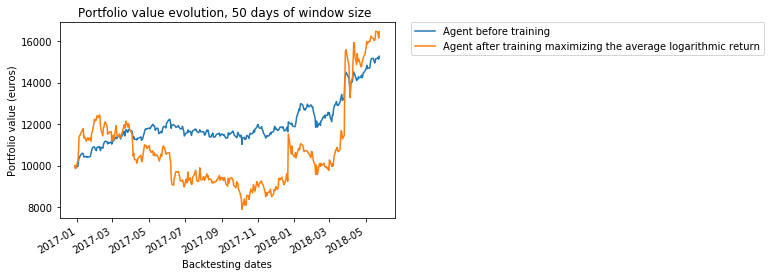

In [11]:
import matplotlib.dates as mdates
dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in val_dates]

fig, ax = plt.subplots()
plt.title('Portfolio value evolution, ' + str(n) + ' days of window size ')
ax.plot(dates, pv_val_not_trained[:], label = 'Agent before training')
ax.plot(dates, pv_val_LR_trained[:], label = 'Agent after training maximizing the average logarithmic return')
# ax.plot(dates, pv_val_S_trained[:], label = 'Agent after training maxmizing the sharpe ratio')
# for i in range(m):
#     ax.plot(p_list_fu[i], label = 'Full Stock {} Portfolio Value'.format(asset_list[i]))
fig.autofmt_xdate()                             
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  
plt.ylabel('Portfolio value (euros)')
plt.xlabel('Backtesting dates')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

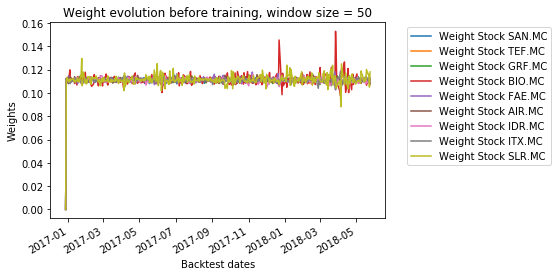

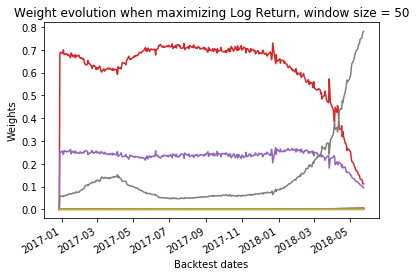

In [12]:
import matplotlib.dates as mdates
dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in val_dates]
names = asset_list


w_list = np.array(w_val_not_trained)
fig, ax = plt.subplots()
for j in range(m):
    ax.plot(dates, w_list[:,j], label = 'Weight Stock {}'.format(names[j]))
    plt.title('Weight evolution before training, window size = ' + str(n))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.xlabel('Backtest dates')
plt.ylabel('Weights')
fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations
plt.show()


w_list = np.array(w_val_LR_trained)
fig, ax = plt.subplots()
for j in range(m):
    ax.plot(dates, w_list[:,j], label = 'Weight Stock {}'.format(names[j]))
    plt.title('Weight evolution when maximizing Log Return, window size = ' + str(n))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.xlabel('Backtest dates')
plt.ylabel('Weights')
fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations
plt.show()


# w_list = np.array(w_val_S_trained)
# fig, ax = plt.subplots()
# for j in range(m):
#     ax.plot(dates, w_list[:,j], label = 'Weight Stock {}'.format(names[j]))
#     plt.title('Weight evolution when maximizing Sharpe Ratio, window size = ' + str(n))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
# plt.xlabel('Backtest dates')
# plt.ylabel('Weights')
# fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations
# plt.show()

### 4.2.2 Test Set

In [ ]:
pv_not_trained, w_not_trained = test_agent(env_log, not_trained, m, n, training_set_periods, validating_set_periods,
                                    testing_set_periods, individual_assets = False)

In [ ]:
env = MarketEnvironment(path = path_data, window_length = n,
               initial_portfolio_value = pf_value_init, trading_cost = trading_cost,
               interest_rate = interest_rate, train_size = training_validating_testing['train_ratio'], LogReturn = True)
pv_trained_LR, w_trained_LR = test_agent(env, trained_agent_LR, m, n, training_set_periods, validating_set_periods,
                                    testing_set_periods, individual_assets = False)

In [ ]:
env = MarketEnvironment(path = path_data, window_length = n,
               initial_portfolio_value = pf_value_init, trading_cost = trading_cost,
               interest_rate = interest_rate, train_size = training_validating_testing['train_ratio'], LogReturn = True)
pv_trained_S, w_trained_S, pv_individual = test_agent(env, trained_agent_S, m, n, training_set_periods, validating_set_periods,
                                    testing_set_periods, individual_assets = True)

#### 4.2.2.1 Plots

In [ ]:
import matplotlib.dates as mdates
dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in test_dates]

fig, ax = plt.subplots()
plt.title('Portfolio value evolution, ' + str(n) + ' days of window size ')
ax.plot(dates, pv_not_trained[1:], label = 'Agent before training')
ax.plot(dates, pv_trained_LR[1:], label = 'Agent after training maximizing the average logarithmic return')
# ax.plot(dates, pv_trained_S[1:], label = 'Agent after training maxmizing the sharpe ratio')
# for i in range(m):
#     ax.plot(p_list_fu[i], label = 'Full Stock {} Portfolio Value'.format(asset_list[i]))
fig.autofmt_xdate()                             
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  
plt.ylabel('Portfolio value (euros)')
plt.xlabel('Backtesting dates')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
import matplotlib.dates as mdates
dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in test_dates]
names = asset_list


w_list = np.array(w_not_trained)
fig, ax = plt.subplots()
for j in range(m):
    ax.plot(dates, w_list[:-1,j], label = 'Weight Stock {}'.format(names[j]))
    plt.title('Weight evolution before training, window size = ' + str(n))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.xlabel('Backtest dates')
plt.ylabel('Weights')
fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations
plt.show()


w_list = np.array(w_trained_LR)
fig, ax = plt.subplots()
for j in range(m):
    ax.plot(dates, w_list[:-1,j], label = 'Weight Stock {}'.format(names[j]))
    plt.title('Weight evolution when maximizing Log Return, window size = ' + str(n))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.xlabel('Backtest dates')
plt.ylabel('Weights')
fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations
plt.show()


# w_list = np.array(w_trained_S)
# fig, ax = plt.subplots()
# for j in range(m):
#     ax.plot(dates, w_list[:-1,j], label = 'Weight Stock {}'.format(names[j]))
#     plt.title('Weight evolution when maximizing Sharpe Ratio, window size = ' + str(n))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
# plt.xlabel('Backtest dates')
# plt.ylabel('Weights')
# fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations
# plt.show()

## 4.3 Asset history

Compute the portfolio value of a single asset portfolio for all the assets in the portfolio, and plot the results. The graph shows what would happen in case that all the cash had been inverted in one of the assets. The computations are made for three different periods:
1. Explore all history: explores from the first data index until the last, therefore, computes the behaviour of the assets along training, validating and testing periods
2. Explore training: explores the asset behaviour in the training dataset allowing one to notify why more weight is being assign to an especific asset.
3. Explore testing: explores the testing set computing the asset behaiour individually to compare it to the performance of the trained agent.

In [ ]:
def compute_individual_asset_portfolio(training_set_periods, validating_set_periods, testing_set_periods, m, n = 0,
                                       explore_all = True, explore_training = False, explore_validating = False, explore_testing = False):
    # Initialize vectors and lists to record values   
    state_fu = [0]*m; done_fu = [0]*m
    action_fu = list(); env_fu = list(); p_list_fu = list()
    for i in range(m):
        action = np.array([0]*(i) + [1] + [0]*(m-(i+1)))
        action_fu.append(action)

        # Window_length is 0 so as to plot all the history of the assets from period t0 to period tf
        # Since the actions are fixed, the net does not compute them, and therefore there is no need 
        # to use a window of previous prives to estimate its potential of grwoth and compute action
        env_fu_i = MarketEnvironment(path=path_data, window_length = n,
                   initial_portfolio_value=pf_value_init, trading_cost=trading_cost,
                   interest_rate=interest_rate, train_size=training_validating_testing['train_ratio'], LogReturn = True)

        env_fu.append(env_fu_i)
        if explore_all or explore_training:
            # t=0 then the index starts in window_length (n) because is the number of previous periods it needs to explore data when training
            state_fu[i],  done_fu[i] = env_fu[i].reset(action_fu[i], pf_value_init, t = 0)
        elif explore_validating:
            state_fu[i],  done_fu[i] = env_fu[i].reset(action_fu[i], pf_value_init, t = training_set_periods)
        elif explore_testing:
            state_fu[i],  done_fu[i] = env_fu[i].reset(action_fu[i], pf_value_init, t = training_set_periods + validating_set_periods)
            
        p_list_fu.append([pf_value_init])

    pf_value_t_fu = [0]*m

    if explore_all:
        for k in range(trading_period - n):
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
                pf_value_t_fu[i] = state_fu[i][2]
                p_list_fu[i].append(pf_value_t_fu[i])
    elif explore_training:
        for k in range(1, training_set_periods - n):
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
                pf_value_t_fu[i] = state_fu[i][2]
                p_list_fu[i].append(pf_value_t_fu[i])
    elif explore_validating:
        for k in range(training_set_periods + 1, training_set_periods + validating_set_periods - n):
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
                pf_value_t_fu[i] = state_fu[i][2]
                p_list_fu[i].append(pf_value_t_fu[i])
    elif explore_testing:
        for k in range(training_set_periods + validating_set_periods + 1, training_set_periods + validating_set_periods + testing_set_periods - n):
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
                pf_value_t_fu[i] = state_fu[i][2]
                p_list_fu[i].append(pf_value_t_fu[i])


    return p_list_fu

# n is the index where the environment starts computing next state -> t0 = n
# To explore all the history of the assets n = 0
asset_price_history = compute_individual_asset_portfolio(training_set_periods, validating_set_periods,
                                                         testing_set_periods, m, n, False, False, False, True)
# asset_price_history = compute_individual_asset_portfolio(training_set_periods, validating_set_periods, testing_set_periods, m, n, True, False, False)

# asset_list = [i for i in range(m)]
import matplotlib.dates as mdates
dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in test_dates]
fig, ax = plt.subplots()
plt.title('Evolution of a portfolio comprised of an individual asset')
plt.xlabel('Backtest dates')
plt.ylabel('Portfolio value (euros)')
for i in range(m):
    ax.plot(dates, asset_price_history[i], label = 'Full Stock {} Portfolio Value'.format(asset_list[i]))
#     plt.plot(asset_price_history2[i], label = 'Full Stock {} Portfolio Value'.format(asset_list[i]))
fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()